<a href="https://colab.research.google.com/github/bouzayeniiheb/3rd_Solution_Covid-19-Tweet-Classification-Challenge-/blob/master/3rd_Solution_Covid-19%20_Tweet_Classification_Challenge.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

### **COVID-19 Tweet Classification Challenge by #ZindiWeekendz**

Here is my solution for this hackhaton,
I used two models using fastai with Roberta Large.

I wrote all my code in this notebook with clear comments.

P.S:

*   Please run this code in google colab to get the same results.

*   If you have a problem in cuda memory, please run the second model in another notebook using a second gmail account.Don't forget to import the libraries.





Before starting the implementation, you will need to install the fastai and transformers libraries. 


In [1]:
!pip install torch_nightly -f https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html
!pip install fastai

Looking in links: https://download.pytorch.org/whl/nightly/cu92/torch_nightly.html


In [2]:
! pip install pytorch-transformers

In [3]:
!pip install --upgrade transformers
!pip install simpletransformers

Requirement already up-to-date: transformers in /usr/local/lib/python3.6/dist-packages (2.9.0)


In [9]:
pip install Pillow

Import the necessary librairies

In [0]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from pathlib import Path 

import os

import torch
import torch.optim as optim

import random 

# fastai
from fastai import *
from fastai.text import *
from fastai.callbacks import *

# transformers
from transformers import PreTrainedModel, PreTrainedTokenizer, PretrainedConfig

from transformers import RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig


In [10]:
entrypoints = torch.hub.list('pytorch/vision:v0.4.0', force_reload=True)

Downloading: "https://github.com/pytorch/vision/archive/v0.4.0.zip" to /root/.cache/torch/hub/v0.4.0.zip


In [0]:
from google.colab import files
from tqdm import tqdm
import warnings
warnings.simplefilter('ignore')
import gc
from scipy.special import softmax
from simpletransformers.classification import ClassificationModel
from sklearn.model_selection import train_test_split, StratifiedKFold, KFold
import sklearn
from sklearn.metrics import log_loss
from sklearn.metrics import *
from sklearn.model_selection import *
import re
import random
import torch



The current versions of the fastai and transformers libraries are respectively 1.0.61 and 2.9.0.


In [12]:


import fastai
import transformers
print('fastai version :', fastai.__version__)
print('transformers version :', transformers.__version__)



fastai version : 1.0.61
transformers version : 2.9.0


Read the datasets

In [0]:
TRAIN_PATH = '/content/updated_train.csv'
TEST_PATH = '/content/updated_test.csv'
SAMPLE_SUB_PATH = '/content/updated_ss.csv'
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)
ID_COL, TARGET_COL = sample_sub.columns.tolist()

In [303]:
train.head()

,ID,text,target
0,train_0,The bitcoin halving is cancelled due to,1
1,train_1,MercyOfAllah In good times wrapped in its gran...,0
2,train_2,266 Days No Digital India No Murder of e learn...,1
3,train_3,India is likely to run out of the remaining RN...,1
4,train_4,In these tough times the best way to grow is t...,0


In [304]:
train.describe()

,target
count,5287.000000
mean,0.480613
std,0.499671
min,0.000000
25%,0.000000
50%,0.000000
75%,1.000000
max,1.000000


As we see here the train data set is well balanced

In [305]:
train['target'].value_counts()

0    2746
1    2541
Name: target, dtype: int64

Check missing values in the train and test datafames

In [306]:
train['target'].isnull().sum()

0

In [307]:
train['text'].isnull().sum()

0

In [308]:
test['text'].isnull().sum()

0

### **Roberta Large Model1:**

In [0]:
MODEL_CLASSES = {
    'roberta': (RobertaForSequenceClassification, RobertaTokenizer, RobertaConfig),
}

In [0]:
seed = 42
use_fp16 = False
bs = 16

model_type = 'roberta'
pretrained_model_name = 'roberta-large'

In [0]:
model_class, tokenizer_class, config_class = MODEL_CLASSES[model_type]



Function to set the seed for generating random numbers.


In [0]:
def seed_all(seed_value):
    random.seed(seed_value) # Python
    np.random.seed(seed_value) # cpu vars
    torch.manual_seed(seed_value) # cpu  vars
    
    if torch.cuda.is_available(): 
        torch.cuda.manual_seed(seed_value)
        torch.cuda.manual_seed_all(seed_value) # gpu vars
        torch.backends.cudnn.deterministic = True  #needed
        torch.backends.cudnn.benchmark = False

In [0]:
seed_all(seed)

**Data pre-processing**


to match pre-training, we have to format the model input sequence in a specific format. To do so, you have to first **tokenize** and then **numericalize** the texts correctly. The difficulty here is that each pre-trained model, that we will fine-tune, requires exactly the same specific pre-process - **tokenization** & **numericalization **- than the pre-process used during the pre-train part. Fortunately, the **tokenizer class** from transformers provides the correct pre-process tools that correspond to each pre-trained model.

In the fastai library, data pre-processing is done automatically during the creation of the DataBunch. As you will see in the DataBunch implementation, the tokenizer and numericalizer are passed in the processor argument under the following format :

processor = [TokenizeProcessor(tokenizer=tokenizer,...), NumericalizeProcessor(vocab=vocab,...)]

Let's first analyse how we can integrate the transformers tokenizer within the TokenizeProcessor function.

*Custom Tokenizer:*

This part can be a little bit confusing because a lot of classes are wrapped in each other and with similar names. To resume, if we look attentively at the fastai implementation, we notice that :


1.   The TokenizeProcessor object takes as tokenizer argument a Tokenizer object.
2.  The Tokenizer object takes as tok_func argument a BaseTokenizer object.
3. The BaseTokenizer object implement the function tokenizer(t:str) → List[str] that take a text t and returns the list of its tokens.

Therefore, we can simply create a new class TransformersBaseTokenizer that inherits from BaseTokenizer and overwrite a new tokenizer function.


In [0]:
class TransformersBaseTokenizer(BaseTokenizer):
    """Wrapper around PreTrainedTokenizer to be compatible with fast.ai"""
    def __init__(self, pretrained_tokenizer: PreTrainedTokenizer, model_type = 'bert', **kwargs):
        self._pretrained_tokenizer = pretrained_tokenizer
        self.max_seq_len = pretrained_tokenizer.max_len
        self.model_type = model_type

    def __call__(self, *args, **kwargs): 
        return self

    def tokenizer(self, t:str) -> List[str]:
        """Limits the maximum sequence length and add the spesial tokens"""
        CLS = self._pretrained_tokenizer.cls_token
        SEP = self._pretrained_tokenizer.sep_token
        if self.model_type in ['roberta']:
            tokens = self._pretrained_tokenizer.tokenize(t, add_prefix_space=True)[:self.max_seq_len - 2]
            tokens = [CLS] + tokens + [SEP]
        
        return tokens

In [0]:


transformer_tokenizer = tokenizer_class.from_pretrained(pretrained_model_name)
transformer_base_tokenizer = TransformersBaseTokenizer(pretrained_tokenizer = transformer_tokenizer, model_type = model_type)
fastai_tokenizer = Tokenizer(tok_func = transformer_base_tokenizer, pre_rules=[], post_rules=[])




*Custom Numericalizer:*

In fastai, NumericalizeProcessor object takes as vocab argument a Vocab object. From this analyse, I suggest one way to adapt the fastai numericalizer:


1.   Create a new class TransformersVocab that inherits from Vocab and overwrite numericalize and textify functions.

this solution runs for each model type. It consists of using the functions convert_tokens_to_ids and convert_ids_to_tokens in respectively numericalize and textify.



In [0]:
class TransformersVocab(Vocab):
    def __init__(self, tokenizer: PreTrainedTokenizer):
        super(TransformersVocab, self).__init__(itos = [])
        self.tokenizer = tokenizer
    
    def numericalize(self, t:Collection[str]) -> List[int]:
        "Convert a list of tokens `t` to their ids."
        return self.tokenizer.convert_tokens_to_ids(t)

    def textify(self, nums:Collection[int], sep=' ') -> List[str]:
        "Convert a list of `nums` to their tokens."
        nums = np.array(nums).tolist()
        return sep.join(self.tokenizer.convert_ids_to_tokens(nums)) if sep is not None else self.tokenizer.convert_ids_to_tokens(nums)
    
    def __getstate__(self):
        return {'itos':self.itos, 'tokenizer':self.tokenizer}

    def __setstate__(self, state:dict):
        self.itos = state['itos']
        self.tokenizer = state['tokenizer']
        self.stoi = collections.defaultdict(int,{v:k for k,v in enumerate(self.itos)})



NB: The functions __gestate__ and __setstate__ allow the functions export and load_learner to work correctly with TransformersVocab.


*Setting up the Databunch:*




There is multiple ways to create a DataBunch, in my implementation, I use the data block API, which gives more flexibility.


In [0]:
transformer_vocab =  TransformersVocab(tokenizer = transformer_tokenizer)
numericalize_processor = NumericalizeProcessor(vocab=transformer_vocab)

tokenize_processor = TokenizeProcessor(tokenizer=fastai_tokenizer, include_bos=False, include_eos=False)

transformer_processor = [tokenize_processor, numericalize_processor]

In [0]:
pad_first = bool(model_type in ['xlnet'])
pad_idx = transformer_tokenizer.pad_token_id

In [319]:
databunch = (TextList.from_df(train, cols='text', processor=transformer_processor)
             .split_by_rand_pct(0.1,seed=seed)
             .label_from_df(cols= 'target')
             .add_test(test)
             .databunch(bs=bs, pad_first=pad_first, pad_idx=pad_idx))

*Custom model:*

every model's forward method always outputs a tuple with various elements depending on the model and the configuration parameters. In our case, we are interested to access only to the logits.  One way to access them is to create a custom model.

In [0]:
class CustomTransformerModel(nn.Module):
    def __init__(self, transformer_model: PreTrainedModel):
        super(CustomTransformerModel,self).__init__()
        self.transformer = transformer_model
        
    def forward(self, input_ids, attention_mask=None):
        
        # attention_mask
        # Mask to avoid performing attention on padding token indices.
        # Mask values selected in ``[0, 1]``:
        # ``1`` for tokens that are NOT MASKED, ``0`` for MASKED tokens.
        attention_mask = (input_ids!=pad_idx).type(input_ids.type()) 
        
        logits = self.transformer(input_ids,
                                  attention_mask = attention_mask)[0]   
        return logits



To make our transformers adapted to multiclass classification, before loading the pre-trained model, we need to precise the number of labels

In [321]:
config = config_class.from_pretrained(pretrained_model_name)
config.num_labels = 2
config.use_bfloat16 = use_fp16
print(config)

RobertaConfig {
  "architectures": [
    "RobertaForMaskedLM"
  ],
  "attention_probs_dropout_prob": 0.1,
  "bos_token_id": 0,
  "eos_token_id": 2,
  "hidden_act": "gelu",
  "hidden_dropout_prob": 0.1,
  "hidden_size": 1024,
  "initializer_range": 0.02,
  "intermediate_size": 4096,
  "layer_norm_eps": 1e-05,
  "max_position_embeddings": 514,
  "model_type": "roberta",
  "num_attention_heads": 16,
  "num_hidden_layers": 24,
  "pad_token_id": 1,
  "type_vocab_size": 1,
  "vocab_size": 50265
}



In [0]:
transformer_model = model_class.from_pretrained(pretrained_model_name, config = config)

custom_transformer_model = CustomTransformerModel(transformer_model = transformer_model)

*Learner : Custom Optimizer / Custom Metric:*

In pytorch-transformers, HuggingFace had implemented two specific optimizers  -  BertAdam and OpenAIAdam  -  that have been replaced by a single AdamW optimizer. This optimizer matches Pytorch Adam optimizer Api, therefore, it becomes straightforward to integrate it within fastai. It is worth noting that for reproducing BertAdam specific behavior, you have to set correct_bias = False.




In [0]:
from fastai.callbacks import *
from transformers import AdamW
from functools import partial

CustomAdamW = partial(AdamW, correct_bias=False)

learner = Learner(databunch, 
                  custom_transformer_model, 
                  opt_func = CustomAdamW, 
                  metrics=[accuracy, error_rate])

# Show graph of learner stats and metrics after each epoch.
learner.callbacks.append(ShowGraph(learner))

# Put learn in FP16 precision mode. --> Seems to not working
if use_fp16: learner = learner.to_fp16()

I can decide to divide the model in 14 blocks :


*   1 Embedding
*   12 transformer
*   1 classifier

In this case, we can split our model in this way :

In [0]:
list_layers = [learner.model.transformer.roberta.embeddings,
              learner.model.transformer.roberta.encoder.layer[0],
              learner.model.transformer.roberta.encoder.layer[1],
              learner.model.transformer.roberta.encoder.layer[2],
              learner.model.transformer.roberta.encoder.layer[3],
              learner.model.transformer.roberta.encoder.layer[4],
              learner.model.transformer.roberta.encoder.layer[5],
              learner.model.transformer.roberta.encoder.layer[6],
              learner.model.transformer.roberta.encoder.layer[7],
              learner.model.transformer.roberta.encoder.layer[8],
              learner.model.transformer.roberta.encoder.layer[9],
              learner.model.transformer.roberta.encoder.layer[10],
              learner.model.transformer.roberta.encoder.layer[11],
              learner.model.transformer.roberta.pooler]



Check groups :


In [325]:
learner.split(list_layers)
num_groups = len(learner.layer_groups)
print('Learner split in',num_groups,'groups')
print(learner.layer_groups)

Learner split in 14 groups
[Sequential(
  (0): Embedding(50265, 1024, padding_idx=1)
  (1): Embedding(514, 1024, padding_idx=1)
  (2): Embedding(1, 1024)
  (3): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (4): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=1024, bias=True)
  (2): Linear(in_features=1024, out_features=1024, bias=True)
  (3): Dropout(p=0.1, inplace=False)
  (4): Linear(in_features=1024, out_features=1024, bias=True)
  (5): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (6): Dropout(p=0.1, inplace=False)
  (7): Linear(in_features=1024, out_features=4096, bias=True)
  (8): Linear(in_features=4096, out_features=1024, bias=True)
  (9): LayerNorm((1024,), eps=1e-05, elementwise_affine=True)
  (10): Dropout(p=0.1, inplace=False)
), Sequential(
  (0): Linear(in_features=1024, out_features=1024, bias=True)
  (1): Linear(in_features=1024, out_features=10

*Train*

Now we can finally use all the fastai build-in features to train our model. Like the ULMFiT method, we will use Slanted Triangular Learning Rates, Discriminate Learning Rate and gradually unfreeze the model.

In [0]:
learner.save('untrain')

In [0]:
seed_all(seed)
learner.load('untrain');



Therefore, we first freeze all the groups but the classifier with :


In [0]:
learner.freeze_to(-1)



We check which layer are trainable.


In [329]:
learner.summary()

CustomTransformerModel
Layer (type)         Output Shape         Param #    Trainable 
Embedding            [85, 1024]           51,471,360 False     
______________________________________________________________________
Embedding            [85, 1024]           526,336    False     
______________________________________________________________________
Embedding            [85, 1024]           1,024      False     
______________________________________________________________________
LayerNorm            [85, 1024]           2,048      False     
______________________________________________________________________
Dropout              [85, 1024]           0          False     
______________________________________________________________________
Linear               [85, 1024]           1,049,600  False     
______________________________________________________________________
Linear               [85, 1024]           1,049,600  False     
_______________________________________

For Slanted Triangular Learning Rates you have to use the function one_cycle.

To use our one_cycle we will need an optimum learning rate. We can find this learning rate by using a learning rate finder which can be called by using lr_find.

In [330]:
learner.lr_find()

epoch,train_loss,valid_loss,accuracy,error_rate,time


LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.


Min numerical gradient: 6.31E-07
Min loss divided by 10: 9.12E-08


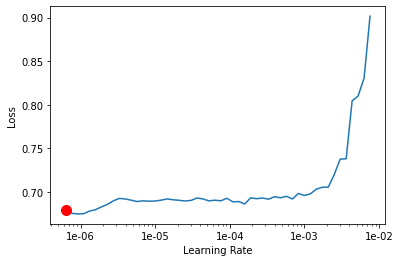

In [331]:
learner.recorder.plot(skip_end=10,suggestion=True)


I will pick a value a bit before the minimum, where the loss still improves. Here 2x10^-3 seems to be a good value.

Next I will use fit_one_cycle with the chosen learning rate as the maximum learning rate.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.416115,0.328555,0.856061,0.143939,01:12


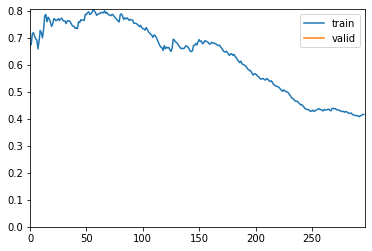

In [332]:
learner.fit_one_cycle(1,max_lr=2e-03,moms=(0.8,0.7))

In [0]:
learner.save('first_cycle')

In [0]:


seed_all(seed)
learner.load('first_cycle');





I then unfreeze the second group of layers and repeat the operations.


In [0]:
learner.freeze_to(-2)

In [0]:
lr = 1e-5



Note here that i use slice to create separate learning rate for each group.


epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.232635,0.214913,0.905303,0.094697,02:40


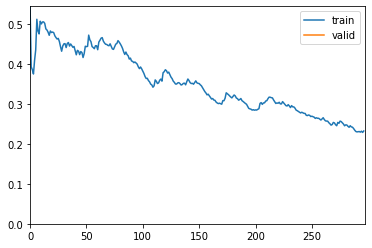

In [337]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr),moms=(0.8,0.9))

In [0]:
learner.save('second_cycle')

In [0]:
seed_all(seed)
learner.load('second_cycle');

In [0]:
learner.freeze_to(-3)

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.182978,0.212460,0.910985,0.089015,02:49


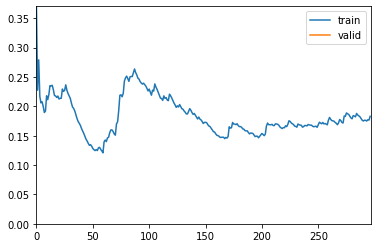

In [341]:
learner.fit_one_cycle(1, max_lr=slice(lr*0.95**num_groups, lr),moms=(0.8,0.9))

In [0]:
learner.save('third_cycle')

In [0]:
seed_all(seed)
learner.load('third_cycle');



Here, I unfreeze all the groups.


In [0]:
learner.unfreeze()

epoch,train_loss,valid_loss,accuracy,error_rate,time
0,0.255679,0.236354,0.888258,0.111742,04:06
1,0.159158,0.215915,0.903409,0.096591,03:59


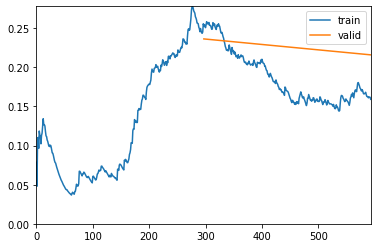

In [345]:
learner.fit_one_cycle(2, max_lr=slice(lr*0.95**num_groups, lr),moms=(0.8,0.9))

***Prediction:***

Try an example of the test set:

In [346]:
learner.predict('How Boris Johnson s cheery wounded in action persona may save him yet again Let s hope not Johnso')

(Category tensor(1), tensor(1), tensor([0.0017, 0.9983]))

Make all the predictions:

In [0]:
prediction=[]
for i in test.text:
  p=learner.predict(i)
  sample_prediction=p[2][1].tolist()
  prediction.append(sample_prediction)

In [348]:
len(prediction)

1962

In [379]:
prediction[0:5]

[0.9931851029396057,
 2.886372385546565e-05,
 2.3880702428868972e-05,
 0.9983425140380859,
 1.2061724191880785e-05]

## **Roberta Large Model2:**

In this part, I use another notebook because i tried the batchsize 32 so if you face an error  (Cuda out of memory) please run this code separently and don't forget to import the Libraires in the beginning of the notebook.


In [0]:
TRAIN_PATH = '/content/updated_train.csv'
TEST_PATH = '/content/updated_test.csv'
SAMPLE_SUB_PATH = '/content/updated_ss.csv'
train = pd.read_csv(TRAIN_PATH)
test = pd.read_csv(TEST_PATH)
sample_sub = pd.read_csv(SAMPLE_SUB_PATH)
ID_COL, TARGET_COL = sample_sub.columns.tolist()

In [0]:
train1=train.drop(['ID'],axis=1)
testt=test.drop(['ID'],axis=1)
testt['label']=0


Define the parameters of the model:

In [0]:
argss = {'train_batch_size':32,
                                                                         'reprocess_input_data': True,
                                                                         'overwrite_output_dir': True,
                                                                         'fp16': False,
                                                                         'do_lower_case': False,
                                                                         'num_train_epochs': 2,
                                                                         'max_seq_length': 64,
                                                                         'regression': False,
                                                                         'manual_seed': 2,
                                                                         "learning_rate":3e-5,
                                                                         'weight_decay':0,
                                                                         "save_eval_checkpoints": False,
                                                                         "save_model_every_epoch": False,
                                                                         "silent": True}

train the model:


In [380]:
erreur=[]
pred2=[]
fold=StratifiedKFold(n_splits=20, shuffle=True, random_state=2)
for train_index, test_index in fold.split(train1,train1['target']):
    train1_trn, train1_val = train1.iloc[train_index], train1.iloc[test_index]
    model = ClassificationModel('roberta', 'roberta-large', use_cuda=True,num_labels=2, args=argss)
    model.train_model(train1_trn)
    raw_outputs_val = model.eval_model(train1_val)[1]
    raw_outputs_val = softmax(raw_outputs_val,axis=1)[:,1]
    print(f"Log_Loss: {log_loss(train1_val['target'], raw_outputs_val)}")
    erreur.append(log_loss(train1_val['target'], raw_outputs_val))
    raw_outputs_test = model.eval_model(testt)[1]
    raw_outputs_test = softmax(raw_outputs_test,axis=1)[:,1]
    pred2.append(raw_outputs_test)
prediction_2=np.mean(pred2, 0)


Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f2060047258>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/notebook.py", line 220, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'
Exception ignored in: <generator object tqdm_notebook.__iter__ at 0x7f205c8c3d00>
Traceback (most recent call last):
  File "/usr/local/lib/python3.6/dist-packages/tqdm/notebook.py", line 220, in __iter__
    self.sp(bar_style='danger')
AttributeError: 'tqdm_notebook' object has no attribute 'sp'


RuntimeError: ignored

In [0]:
predicition2=prediction_2.tolist()

Final result after running the two models:

In [0]:
result=[]
for i in range(0,len(prediction)):
  h=0.75*prediction2[i]+0.25*prediction[i]
  result.append(h)

In [0]:
sample_sub.target=result

In [0]:
sample_sub.to_csv('larabe.csv',index=False)#0.1658